In [266]:
#Import all required libraries
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import random
import math
import seaborn as sns

#sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score

#Not a new window
%matplotlib inline
plt.rcParams['xtick.labelsize'] = 25
plt.rcParams['ytick.labelsize'] = 25

In [276]:
#Import the data files
data = pd.read_csv('./bank-additional-full.csv', sep=';')
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [277]:
# Separating inputs and target variables
X = data.drop(['y'], axis=1)
y = data['y']
print X.head()
print y.head()

   age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  duration  campaign  pdays  previous     poutcome  \
0   may         mon       261         1    999         0  nonexistent   
1   may         mon       149         1    999         0  nonexistent   
2   may         mon       226         1    999         0  nonexistent   
3   may         mon       151         1    999         0  nonexistent   
4   may         mon       307         1    999         0  nonexistent   

   emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  nr.employed  
0           1.1          93.994

In [278]:
#Describe the data to identify the missing data
#Describe categorical data
def describe_categorical(X):
    from IPython.display import display, HTML
    display(HTML(X[X.columns[X.dtypes == 'object']].describe().to_html()))
print X.info()
print X.describe()
print describe_categorical(X)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 20 columns):
age               41188 non-null int64
job               41188 non-null object
marital           41188 non-null object
education         41188 non-null object
default           41188 non-null object
housing           41188 non-null object
loan              41188 non-null object
contact           41188 non-null object
month             41188 non-null object
day_of_week       41188 non-null object
duration          41188 non-null int64
campaign          41188 non-null int64
pdays             41188 non-null int64
previous          41188 non-null int64
poutcome          41188 non-null object
emp.var.rate      41188 non-null float64
cons.price.idx    41188 non-null float64
cons.conf.idx     41188 non-null float64
euribor3m         41188 non-null float64
nr.employed       41188 non-null float64
dtypes: float64(5), int64(5), object(10)
memory usage: 6.3+ MB
None
               age     

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome
count,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188
unique,12,4,8,3,3,3,2,10,5,3
top,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent
freq,10422,24928,12168,32588,21576,33950,26144,13769,8623,35563


None


In [279]:
#Correct ambiguous data: if we have data of outcome and previous contacted has a non-zero number, we need to update the pdays to 6 which is an average
X.pdays[(X['pdays'] == 999) & (X['previous'] != 0) & (X['poutcome'] != 'nonexistant')] = 6

X.head()

/Users/kaingle/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0


In [280]:
#Default, housing, contact, pcoutcome and loan are the best. Hotcoding the data with few variations and eliminating the unknowns
X = pd.get_dummies(X, columns=['default','housing','loan','contact','poutcome', 'marital', 'job', 'education' , 'month', 'day_of_week'])


In [281]:
#Remove the unknown and nonexistant columns
X = X.drop(['job_unknown', 'education_unknown' , 'default_unknown','housing_unknown','loan_unknown','poutcome_nonexistent', 'marital_unknown'], axis=1)
X.head()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed
0,56,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0,1,0,0,0,0,1,0,0,0
1,57,149,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0,1,0,0,0,0,1,0,0,0
2,37,226,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0,1,0,0,0,0,1,0,0,0
3,40,151,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0,1,0,0,0,0,1,0,0,0
4,56,307,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0,1,0,0,0,0,1,0,0,0


In [282]:
#Separate into test and training data
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.1, random_state=42)


In [285]:
print X_train.head()
for i in X_train.columns:
    if X_train[i].dtype == 'uint8':
        X_train[i] = X_train[i].astype(int)
    
print X_train.info()

       age  duration  campaign  pdays  previous  emp.var.rate  cons.price.idx  \
38651   22       358         1    999         0          -3.4          92.649   
12733   52       262         1    999         0           1.4          93.918   
35807   47       953         3    999         0          -1.8          92.893   
1423    38       403         2    999         0           1.1          93.994   
52      60       253         1    999         0           1.1          93.994   

       cons.conf.idx  euribor3m  nr.employed       ...         month_mar  \
38651          -30.1      0.720       5017.5       ...                 0   
12733          -42.7      4.962       5228.1       ...                 0   
35807          -46.2      1.244       5099.1       ...                 0   
1423           -36.4      4.855       5191.0       ...                 0   
52             -36.4      4.857       5191.0       ...                 0   

       month_may  month_nov  month_oct  month_sep  day_o

/Users/kaingle/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


<class 'pandas.core.frame.DataFrame'>
Int64Index: 37069 entries, 38651 to 15795
Data columns (total 56 columns):
age                              37069 non-null int64
duration                         37069 non-null int64
campaign                         37069 non-null int64
pdays                            37069 non-null int64
previous                         37069 non-null int64
emp.var.rate                     37069 non-null float64
cons.price.idx                   37069 non-null float64
cons.conf.idx                    37069 non-null float64
euribor3m                        37069 non-null float64
nr.employed                      37069 non-null float64
default_no                       37069 non-null int64
default_yes                      37069 non-null int64
housing_no                       37069 non-null int64
housing_yes                      37069 non-null int64
loan_no                          37069 non-null int64
loan_yes                         37069 non-null int64
contact_cellu

In [286]:
#Numerical variables for a quick model. The value numeric uses only numeric inputs from the dataframe
numeric = list(X_train.dtypes[X_train.dtypes != 'object'].index)
#example:
print X_train[numeric].head()
print X_train[numeric].describe()

#Convert yes and no to 1 and 0 for y_train and y_test
y_train = y_train.map(dict(yes=1, no=0))
y_test = y_test.map(dict(yes=1, no=0))

#print y_train[0]
#print len(y_train)


       age  duration  campaign  pdays  previous  emp.var.rate  cons.price.idx  \
38651   22       358         1    999         0          -3.4          92.649   
12733   52       262         1    999         0           1.4          93.918   
35807   47       953         3    999         0          -1.8          92.893   
1423    38       403         2    999         0           1.1          93.994   
52      60       253         1    999         0           1.1          93.994   

       cons.conf.idx  euribor3m  nr.employed       ...         month_mar  \
38651          -30.1      0.720       5017.5       ...                 0   
12733          -42.7      4.962       5228.1       ...                 0   
35807          -46.2      1.244       5099.1       ...                 0   
1423           -36.4      4.855       5191.0       ...                 0   
52             -36.4      4.857       5191.0       ...                 0   

       month_may  month_nov  month_oct  month_sep  day_o

In [299]:
#First cut model with set variables for continuous data using a standard fix set of parameters:
#n_estimators=100, oob_score=True, random_state=42

model = RandomForestRegressor(n_estimators=1000, n_jobs=-1, oob_score=True, random_state=42, max_features=0.2, min_samples_leaf=5)
model.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.2, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=5, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

In [300]:
#Check c-stat = roc_auc_score(y, model.oob_prediction_)
y_oob = model.oob_prediction_
print "c-stat: ", roc_auc_score(y_train, y_oob)

c-stat:  0.949295975207


In [301]:
#Test the fit with test data
y_pred = model.predict(X_test[numeric])
print "c-stat: ", roc_auc_score(y_test, y_pred)


c-stat:  0.943477905742


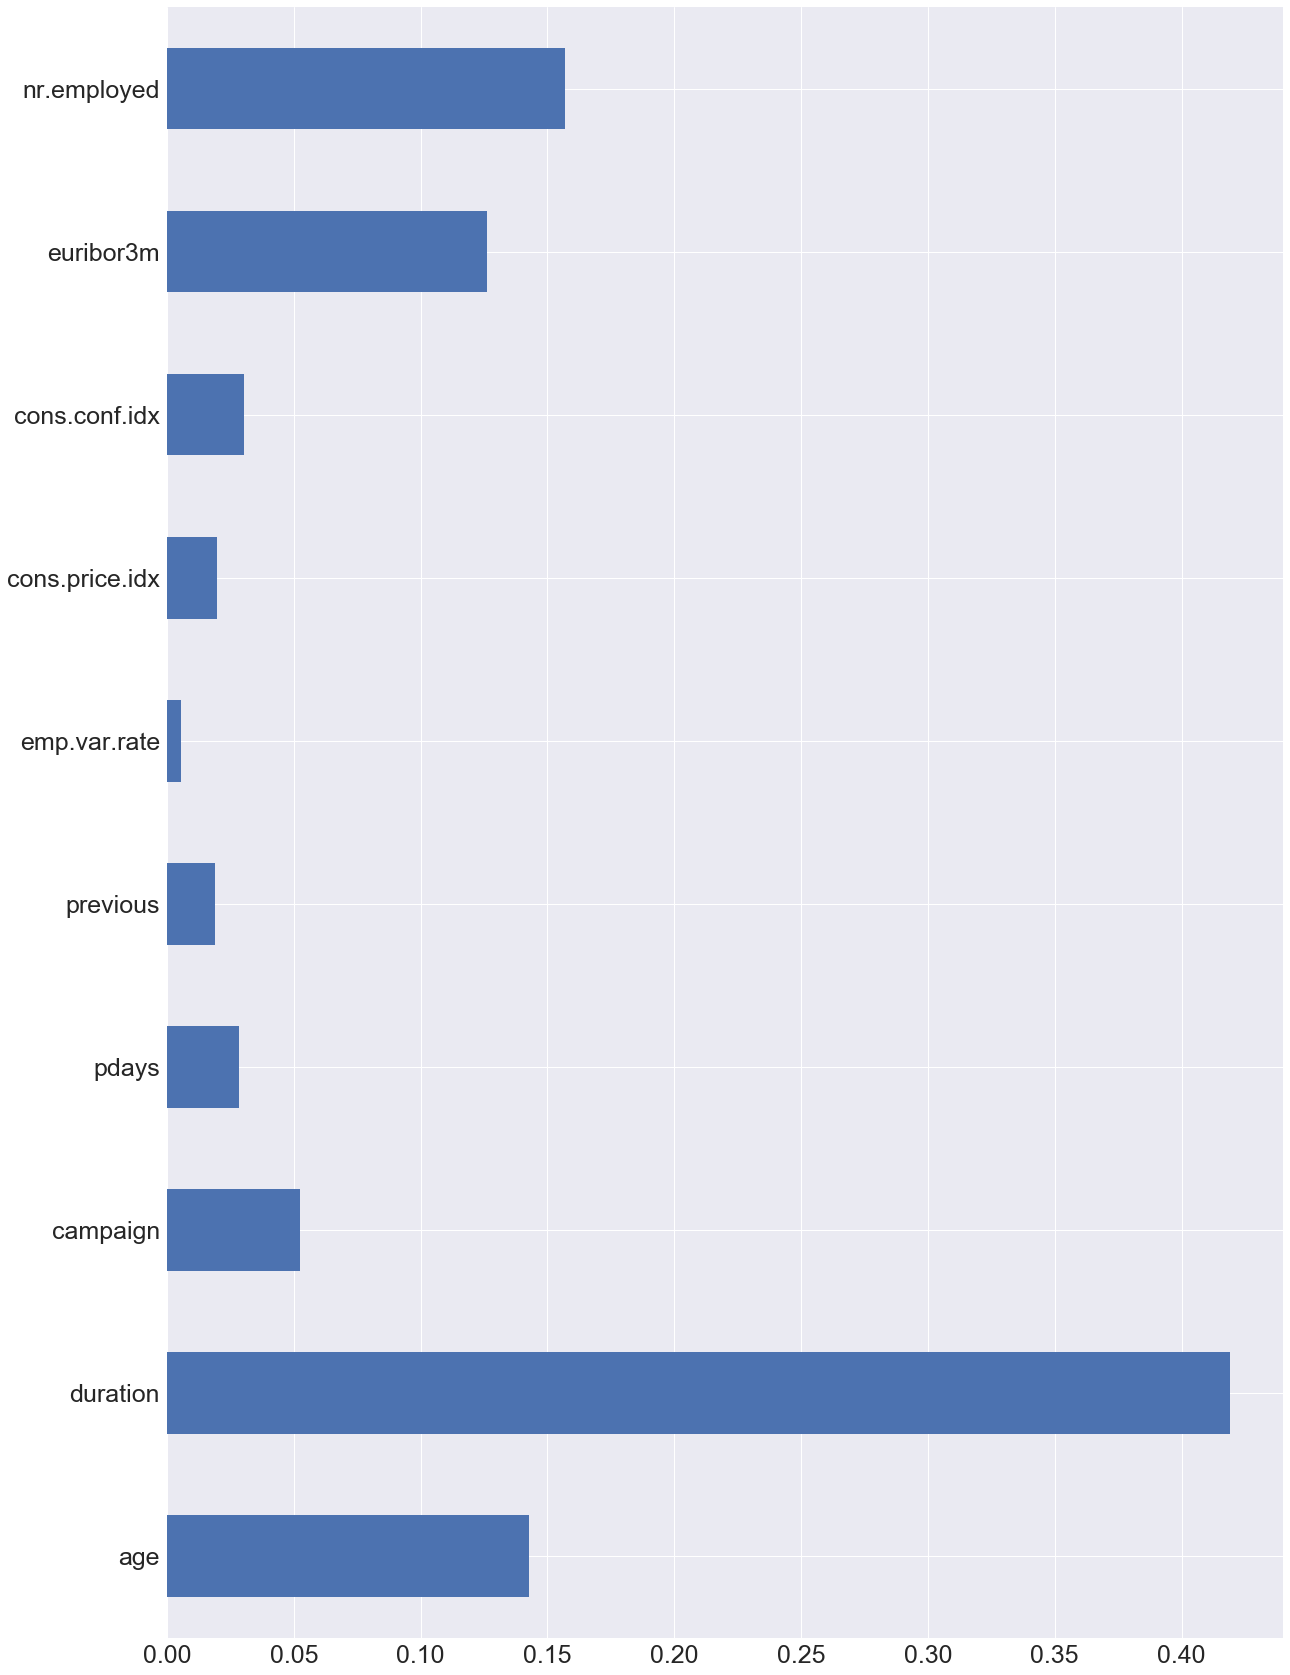

In [223]:
#Feature engineering of continuous variables to improve benchmark of 0.921785
feature_importances = pd.Series(model.feature_importances_, index=X_train[numeric].columns)
feature_importances.sort_values()
feature_importances.plot(kind="barh", figsize=(20,30))

In [224]:
#Selection of features based on scores for each based on models; n_estimators, max_features, min_samples_leaf, n_jobs



In [227]:
%%timeit
model = RandomForestRegressor(1000, oob_score=True, n_jobs=-1, random_state=42)

The slowest run took 7.01 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 5.27 µs per loop


In [228]:
%%timeit
model = RandomForestRegressor(1000, oob_score=True, n_jobs=1, random_state=42)

The slowest run took 5.24 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 5.37 µs per loop


10 Number of trees
C-stat:  0.855088457532
 
50 Number of trees
C-stat:  0.929130684334
 
100 Number of trees
C-stat:  0.936866474944
 
500 Number of trees
C-stat:  0.943201068752
 
1000 Number of trees
C-stat:  0.944169565753
 
2000 Number of trees
C-stat:  0.944492560607
 
4000 Number of trees
C-stat:  0.944991328612
 


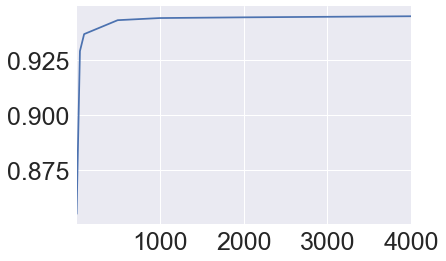

In [292]:
#Testing the best sample size for the model
result = []
n_est_list = [10,50,100,500,1000,2000,4000]

for trees in n_est_list:
    model = RandomForestRegressor(trees, oob_score=True, n_jobs=-1, random_state=42)
    model.fit(X_train,y_train)
    print trees, "Number of trees"
    roc = roc_auc_score(y_train, model.oob_prediction_)
    print "C-stat: ", roc
    result.append(roc)
    print " "
    
pd.Series(result, n_est_list).plot()


In [295]:
#Testing the best max number of features for the model
result = []
max_features = ['auto', None, 'sqrt', 'log2', 0.9, 0.2]

for features in max_features:
    model = RandomForestRegressor(1000, oob_score=True, n_jobs=-1, random_state=42, max_features=features)
    model.fit(X_train,y_train)
    print max_features, "Number of features"
    roc = roc_auc_score(y_train, model.oob_prediction_)
    print "C-stat: ", roc
    result.append(roc)
    print " "
    
pd.Series(result, n_est_list).plot()

['auto', None, 'sqrt', 'log2', 0.9, 0.2] Number of features
C-stat:  0.944169565753
 
['auto', None, 'sqrt', 'log2', 0.9, 0.2] Number of features
C-stat:  0.944169565753
 
['auto', None, 'sqrt', 'log2', 0.9, 0.2] Number of features
C-stat:  0.943705101692
 
['auto', None, 'sqrt', 'log2', 0.9, 0.2] Number of features
C-stat:  0.941081657666
 
['auto', None, 'sqrt', 'log2', 0.9, 0.2] Number of features
C-stat:  0.944765835116
 
['auto', None, 'sqrt', 'log2', 0.9, 0.2] Number of features
C-stat:  0.946032097489
 


ValueError: Wrong number of items passed 6, placement implies 7

3 Number of leaf
C-stat:  0.948626662601
 
4 Number of leaf
C-stat:  0.949138583847
 
5 Number of leaf
C-stat:  0.949295975207
 
6 Number of leaf
C-stat:  0.949292111101
 


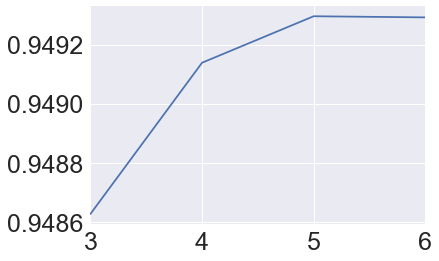

In [298]:
#Testing the best max number of features for the model
result = []
min_leaf = [3,4,5,6]

for leaf in min_leaf:
    model = RandomForestRegressor(1000, oob_score=True, n_jobs=-1, random_state=42, max_features=0.2, min_samples_leaf=leaf)  
    model.fit(X_train,y_train)
    print leaf, "Number of leaf"
    roc = roc_auc_score(y_train, model.oob_prediction_)
    print "C-stat: ", roc
    result.append(roc)
    print " "
    
pd.Series(result, min_leaf).plot()